# What Makes Concrete Strong?
- Concrete is made from a number of ingredients, such as Cement, water and fly ash. Its compressive strength varies as the proportion of ingredients change, and as the concrete ages. 
- An experiment was performed by the Department of Civil Engineering, Chung-Hua University, in which over 1,000 batches of concrete were mixed, allowed to age over various number of days, then tested to find their compressive strength.
- The objective is to see if simple regressors, such as k-nearest neighbour and random forests can predict the compressive strength of the concrete and determine which of the ingredients has the largest effect on compressive strength.
- A simple Neural Net with one hidden layers was also tested.

In [1]:
# Import Libraries
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler  
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn as nn

In [2]:
# Import data into pandas dataframe and shuffle

df = read_csv('./Concrete_data_2.csv')
df = shuffle(df)
df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Days,Compressive Strength
467,250.0,0.0,95.7,191.8,5.3,948.9,857.2,100,41.16
287,181.4,0.0,167.0,169.6,7.6,1055.6,777.8,56,35.57
726,331.0,0.0,0.0,192.0,0.0,1025.0,821.0,3,14.31
828,522.0,0.0,0.0,146.0,0.0,896.0,896.0,28,74.99
985,255.3,98.8,77.0,188.6,6.5,919.0,749.3,28,33.80


In [3]:
# Check data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1030 entries, 467 to 181
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Cement                1030 non-null   float64
 1   Blast Furnace  Slag   1030 non-null   float64
 2   Fly Ash               1030 non-null   float64
 3   Water                 1030 non-null   float64
 4   Superplasticizer      1030 non-null   float64
 5   Coarse Aggregate      1030 non-null   float64
 6   Fine Aggregate        1030 non-null   float64
 7   Days                  1030 non-null   int64  
 8   Compressive Strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 80.5 KB


In [4]:
# Convert the dataframe into a numpy array.
# Split the table into 'train' and 'test' sets.
# Split the two sets into predictors 'X', which are scaled,
# and targets 'y'. The target 

table_data = df.to_numpy()

train_length = int(0.8*df.shape[0])

train_data = table_data[0:train_length,:]
test_data  = table_data[train_length: ,:]

X_train = train_data[:,:-1]
X_train = StandardScaler().fit_transform(X_train)
y_train = train_data[:, -1]

X_test = test_data[:,:-1]
X_test = StandardScaler().fit_transform(X_test)
y_test = test_data[:, -1]

## Model 1. K Nearest Neighbour

In [5]:
# Just using default settings

neighR = KNeighborsRegressor()
    
neighR.fit(X_train, y_train)

# Test accuracy

y_pred = neighR.predict(X_test)
acc = np.round(100*(1-np.mean(abs(y_pred-y_test)/y_test)), 1)
print('Regressor accuracy on test set:    ',acc,'%')

Regressor accuracy on test set:     74.4 %


In [6]:
# Tune the hyperparameters using gridsearch and cross-validation

# Define our candidate hyperparameters

hp_candidates = [{'n_neighbors'  : [1,2,3,4,5,6], 
                  'weights'      : ['uniform','distance'],
                  'p'            : [2,3,4,5,6],
                  'algorithm'    : ['ball_tree','kd_tree','brute'],
                  'leaf_size'    : [30,40,50,60,70]
                 }]

# Search for best hyperparameters

grid = GridSearchCV(estimator=KNeighborsRegressor(), 
                      param_grid=hp_candidates, 
                      scoring='neg_mean_absolute_percentage_error')

grid.fit(X_train,y_train)

# Display the best parameters

params = grid.best_params_
print('\nBest parameters:',params)


Best parameters: {'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 6, 'p': 2, 'weights': 'distance'}


In [7]:
# Create K nearest neighbour regressor based on grid search

neighR = KNeighborsRegressor(n_neighbors = params['n_neighbors'],
                             algorithm   = params['algorithm'  ],
                             leaf_size   = params['leaf_size'  ],
                             p           = params['p'          ],
                             weights     = params['weights'    ])
    
neighR.fit(X_train, y_train)

# Test accuracy

y_pred_knn = neighR.predict(X_test)
acc = np.round(100*(1-np.mean(abs(y_pred_knn-y_test)/y_test)), 1)
print('Regressor accuracy on test set:    ',acc,'%')


Regressor accuracy on test set:     75.7 %


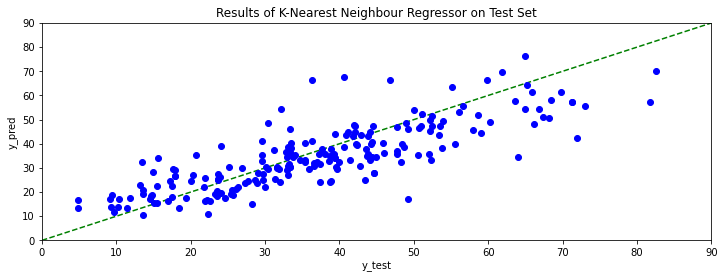

In [8]:
# Plot results comparing test set score against predicted score

plt.figure(facecolor='white', figsize=((12,4)))
plt.plot((0,90),(0,90),'g--')
plt.plot(y_test, y_pred_knn, 'bo')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.xlim((0,90))
plt.ylim((0,90))
plt.title('Results of K-Nearest Neighbour Regressor on Test Set')
plt.show()

## Model 2. Random Forrest

In [9]:
# Create Random Forrest regressor basic default settings

RFR = RandomForestRegressor()
                     
RFR.fit(X_train, y_train)

# Test accuracy

y_pred = RFR.predict(X_test)
acc = np.round(100*(1-np.mean(abs(y_pred-y_test)/y_test)), 1)
print('Regressor accuracy on test set:    ',acc,'%')

Regressor accuracy on test set:     87.2 %


In [10]:
# Tune the hyperparameters using gridsearch and cross-validation

# Define our candidate hyperparameters

hp_candidates = [{'n_estimators'      : [100, 200, 300],
                  'criterion'         : ['squared_error', 
                                         'absolute_error',
                                         'poisson'],
                  'max_features'      : ['sqrt', 
                                         'log2', 
                                          None]  
                 }]

# Search for best hyperparameters

grid = GridSearchCV(estimator  = RandomForestRegressor(),
                    param_grid = hp_candidates, 
                    scoring    = 'neg_mean_absolute_percentage_error')

grid.fit(X_train, y_train)

# Display the best parameters

params = grid.best_params_
print('\nBest parameters:',params)


Best parameters: {'criterion': 'squared_error', 'max_features': None, 'n_estimators': 300}


In [11]:
# Create Random Forrest regressor based on grid search

RFR = RandomForestRegressor(n_estimators = params['n_estimators'],
                            criterion    = params['criterion'],
                            max_features = params['max_features'])
                     
RFR.fit(X_train, y_train)

# Test accuracy

y_pred_rfr = RFR.predict(X_test)
acc = np.round(100*(1-np.mean(abs(y_pred_rfr-y_test)/y_test)), 1)
print('Regressor accuracy on test set:    ',acc,'%')

Regressor accuracy on test set:     87.2 %


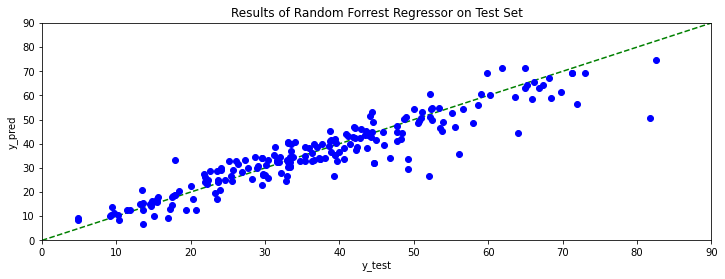

In [12]:
# Plot results comparing test set score against predicted score

plt.figure(facecolor='white', figsize=((12,4)))
plt.plot((0,100),(0,100),'g--')
plt.plot(y_test, y_pred_rfr, 'bo')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.xlim((0,90))
plt.ylim((0,90))
plt.title('Results of Random Forrest Regressor on Test Set')
plt.show()

### Advantage of Random Forest is the ability to extract feature importance

In [13]:
# Exract feature importance from random forrest

feature_importances = RFR.feature_importances_
sorted_idx = list(feature_importances.argsort())
feature_names = df.columns[:-1]


In [14]:
def plot_impurity_metric_features( feature_importances, sorted_idx, feature_names):
    y_ticks = np.arange(0, len(feature_names))
    fig, ax = plt.subplots(figsize=(12, 5),facecolor='white')
    ax.barh(y_ticks, feature_importances[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_title("Random Forest Feature Importances")
    fig.tight_layout()
    plt.show()

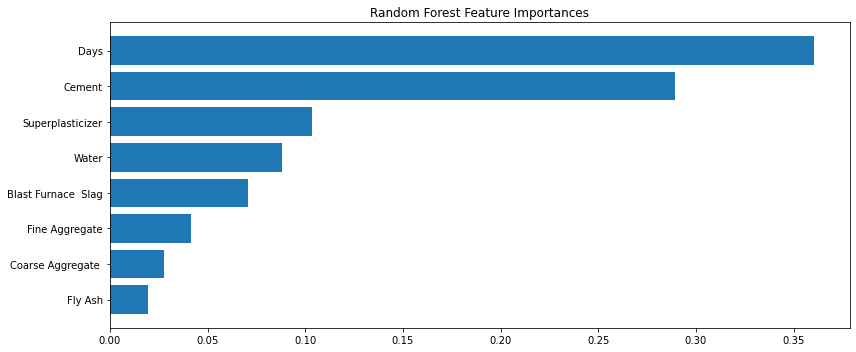

In [15]:
# plot the impurity metric feature importances 
plot_impurity_metric_features( feature_importances, sorted_idx, feature_names)

### Results of Random Forrest
- The results show that the proportion of cement is the most important ingredient for compressive strength, but the number of days the cement is left to cure for is the most important factor.
- The optimised random forest regressor achieved an accuracy of 83% compared to the k nearest neighbour that achieved just 76%


## Neural Net

In [16]:
# Convert training and test sets into torch tensors

y_train = y_train.reshape(-1,1)
y_test  = y_test .reshape(-1,1)

X_trainT = torch.Tensor(X_train)
y_trainT = torch.Tensor(y_train)
X_testT  = torch.Tensor(X_test)
y_testT  = torch.Tensor(y_test)

In [17]:
# The Neurel net defined as a function

def net(X_trainT,
        y_trainT,
        X_testT,
        y_testT,
        n_input,         # number of elements in input layer
        n_hidden,        # number of elements in hidden layer
        act_fun,         # activation function
        loss_function,   
        learning_rate):        

    # The model
    model = nn.Sequential(nn.Linear(n_input, n_hidden),
                          act_fun,
                          nn.Linear(n_hidden, 1))

    # Optimiser
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Train model
    losses = []
    for epoch in range(10000):
        y_predT = model(X_trainT)
        loss = loss_function(y_predT, y_trainT)
        losses.append(loss.item())
        model.zero_grad()
        loss.backward()
        optimizer.step()

    loss_final = losses[-1]

    # Plot the model losses
    plt.figure(facecolor='white')
    plt.plot(losses)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title("Learning rate %f"%(learning_rate))
    plt.show()    

    # Test accuracy on training set (mean absolute error)
    y_predT = model(X_trainT)
    y_pred = y_predT.detach().numpy()
    y_train = y_trainT.detach().numpy()
    acc_test = np.round(100*(1-np.mean(abs(y_pred-y_train)/y_train)), 1)

    # Test accuracy on test set (mean absolute error)
    y_predT = model(X_testT)
    y_pred = y_predT.detach().numpy()
    y_test = y_testT.detach().numpy()
    acc_train = np.round(100*(1-np.mean(abs(y_pred-y_test)/y_test)), 1)
    
    return loss_final, acc_test, acc_train

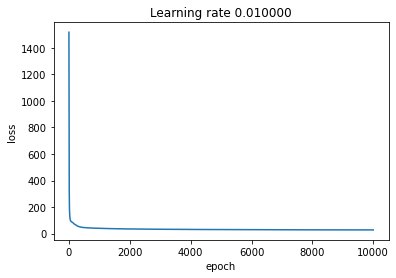

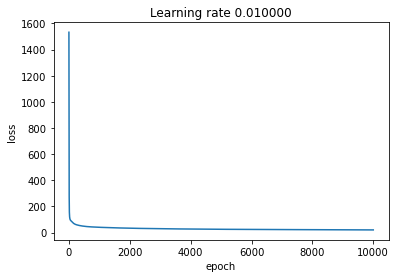

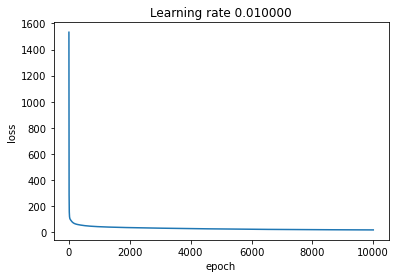

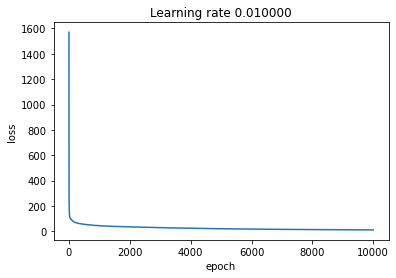

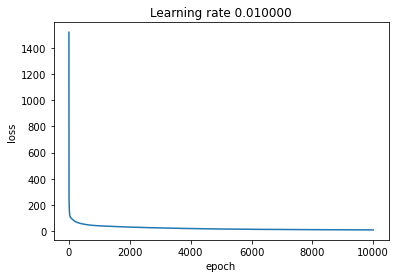

In [18]:
# test the model with different numbers of elements in the hidden layer

n_input   = X_trainT.shape[1]        # number of input layers
n_hidden_list  = [8,16,32,64,128]    # number of elements in hidden layer. Try various values
act_fun   = nn.Sigmoid()             # Activation function. Try Sigmoid, ReLu, softmax, etc.
loss_function = nn.MSELoss()         # loss function based on mean squared error
learning_rate = 0.01   
    
loss_final_list = []    # Final value of loss after model has been trained
acc_train_list  = []    # Accuracy on training set
acc_test_list   = []    # Accuracy on test set
x_plt           = []    # X-axis for plotting

# Test performance of the 'net' for various numbers of elements in hidden layer

for n in n_hidden_list:
    n_hidden = n
    loss_final, acc_test, acc_train = net(X_trainT,
                                        y_trainT,
                                        X_testT,
                                        y_testT,
                                        n_input,
                                        n_hidden,
                                        act_fun,
                                        loss_function,
                                        learning_rate)

    loss_final_list.append(loss_final)
    acc_train_list .append(acc_train)
    acc_test_list  .append(acc_test)
    x_plt          .append(n)

Best accuracy on test set: 92.0 %


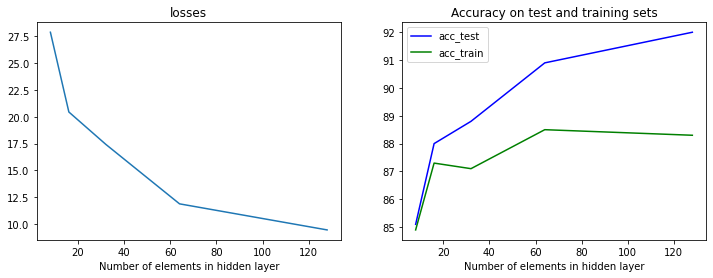

In [19]:
# Display results

# Best accuracy on the test set
print('Best accuracy on test set:',np.round(max(acc_test_list),1),'%')

# Plots
plt.figure(facecolor='white', figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(x_plt,loss_final_list)
plt.xlabel('Number of elements in hidden layer')
plt.title('losses')
plt.subplot(1,2,2)
plt.plot(x_plt,acc_test_list,  'b', label='acc_test')
plt.plot(x_plt,acc_train_list, 'g', label='acc_train')
plt.title('Accuracy on test and training sets')
plt.xlabel('Number of elements in hidden layer')
plt.legend()
plt.show()

### Results of Hyperparameter tuning.

- One hidden layer with 64 elements gives test set accuracy greater than 90%
- Sigmoid is better than ReLU or Softmax
- Adding a second hidden layer only increases accuracy by 1%

### Build Neural net based on best hyperparameters

In [20]:
# The model with best hyperparameters
    
n_input   = X_trainT.shape[1]        # number of input layers
n_hidden  = 64                       # number of elements in hidden layer. Try various values
act_fun   = nn.Sigmoid()             # Activation function. Try Sigmoid, ReLu, softmax, etc.
loss_function = nn.MSELoss()         # loss function based on mean squared error
learning_rate = 0.01  

model_nn = nn.Sequential(nn.Linear(n_input, n_hidden),
                      act_fun,
                      nn.Linear(n_hidden, 1))

# Optimiser
optimizer = torch.optim.SGD(model_nn.parameters(), lr=learning_rate)

# Train model
losses = []
for epoch in range(10000):
    y_predT = model_nn(X_trainT)
    loss = loss_function(y_predT, y_trainT)
    losses.append(loss.item())
    model_nn.zero_grad()
    loss.backward()
    optimizer.step()
    
    
y_predT_nn = model_nn(X_testT)
y_pred_nn  = y_predT_nn.detach().numpy()

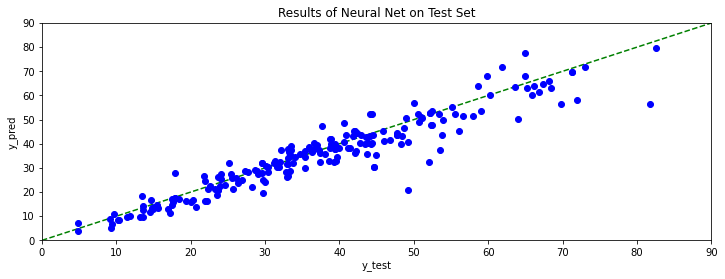

In [21]:
# Plot results comparing test set score against predicted score

plt.figure(facecolor='white', figsize=((12,4)))
plt.plot((0,100),(0,100),'g--')
plt.plot(y_test, y_pred_nn, 'bo')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.xlim((0,90))
plt.ylim((0,90))
plt.title('Results of Neural Net on Test Set')
plt.show()

# Results
- K-nearest neighbour: 67% accuracy on test set
- Random Forest: 83%
- Neural Net with one hidden layer: 92%